## Plotting and checks

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import sys
import numpy as np
import glob

# Import utils
sys.path.append('/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/')
import utils

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


In [3]:
locations = {'Darwin':{'Lat':-12.42,'Lon':130.89,'Elev':30}, # BOM station: 014015
             'Cairns':{'Lat':-16.87,'Lon':145.75,'Elev':2}, # BOM station: 031011
             'Brisbane':{'Lat':-27.48,'Lon':153.04,'Elev':8}, # BOM station: 040913
             'Longreach':{'Lat':-23.44,'Lon':144.28,'Elev':192}, # BOM station: 036031
             'Mildura':{'Lat':-34.23,'Lon':142.09,'Elev':50}, # BOM station: 076031
             'Adelaide':{'Lat':-34.95,'Lon':138.51,'Elev':2}, # BOM station: 023034
             'Perth':{'Lat':-31.92,'Lon':115.87,'Elev':25}, # BOM station: 009225
             'Sydney':{'Lat':-33.95,'Lon':151.17,'Elev':39}, # BOM stations: 066062/066214
             'Melbourne':{'Lat':-37.67,'Lon':144.83,'Elev':31}, # BOM stations: 086071/086338
             'Canberra':{'Lat':-35.31,'Lon':149.19,'Elev':577}, # BOM station: 070351
             'Hobart':{'Lat':-42.89,'Lon':147.33,'Elev':51}, # BOM station: 094029
             'Thredbo':{'Lat':-36.50,'Lon':148.29,'Elev':1380}} # BOM station: 071041



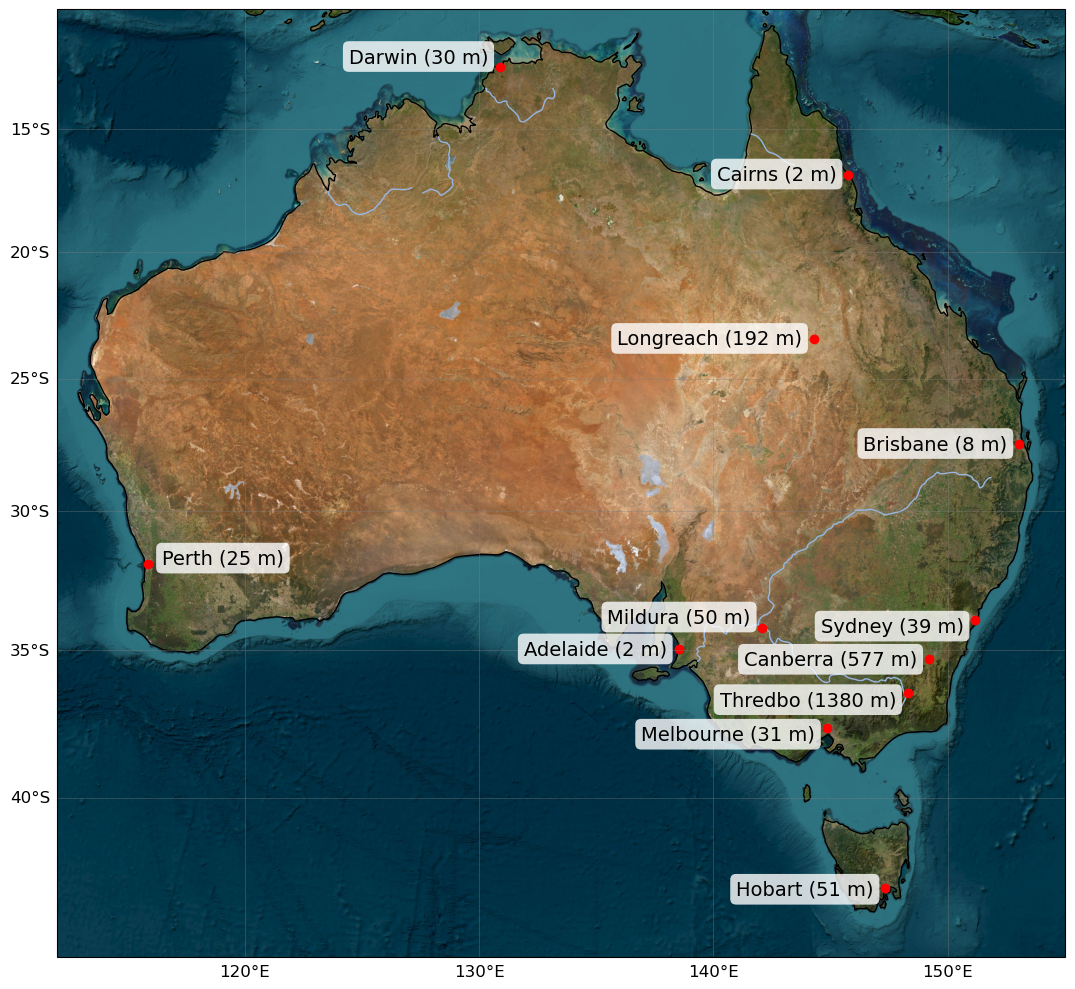

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles
import matplotlib.ticker as mticker

# Custom ESRI imagery tile class
class EsriImagery(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        return f"https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"

# Load basemap
tiler = EsriImagery()
crs = tiler.crs

# Station locations
locations = {
    'Darwin': {'Lat': -12.42, 'Lon': 130.89, 'Elev': 30},
    'Cairns': {'Lat': -16.87, 'Lon': 145.75, 'Elev': 2},
    'Brisbane': {'Lat': -27.48, 'Lon': 153.04, 'Elev': 8},
    'Longreach': {'Lat': -23.44, 'Lon': 144.28, 'Elev': 192},
    'Mildura': {'Lat': -34.23, 'Lon': 142.09, 'Elev': 50},
    'Adelaide': {'Lat': -34.95, 'Lon': 138.51, 'Elev': 2},
    'Perth': {'Lat': -31.92, 'Lon': 115.87, 'Elev': 25},
    'Sydney': {'Lat': -33.95, 'Lon': 151.17, 'Elev': 39},
    'Melbourne': {'Lat': -37.67, 'Lon': 144.83, 'Elev': 31},
    'Canberra': {'Lat': -35.31, 'Lon': 149.19, 'Elev': 577},
    'Hobart': {'Lat': -42.89, 'Lon': 147.33, 'Elev': 51},
    'Thredbo': {'Lat': -36.50, 'Lon': 148.29, 'Elev': 1380}
}

# Adjust all labels to the left of their marker
offsets = {
    name: (-0.5, -0.2) for name in locations
}
# Specific tweaks for better spacing near borders or other cities
offsets.update({
    'Darwin': (-0.5, 0.2),
    'Cairns': (-0.5, -0.2),
    'Brisbane': (-0.5, -0.2),
    'Sydney': (-0.5, -0.4),
    'Canberra': (-0.5, -0.2),
    'Melbourne': (-0.5, -0.4),
    'Thredbo': (-0.5, -0.4),
    'Mildura':(-0.5, 0.2),
    'Perth':(5.8,0)
})

# Plot setup
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=crs)
ax.set_extent([112, 155, -45, -10], crs=ccrs.PlateCarree())
ax.add_image(tiler, 6)

# Features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot stations
for name, info in locations.items():
    lat, lon, elev = info['Lat'], info['Lon'], info['Elev']
    offset_lon, offset_lat = offsets[name]

    ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree())
    ax.text(
        lon + offset_lon, lat + offset_lat,
        f"{name} ({elev} m)",
        fontsize=14,
        color='black',
        transform=ccrs.PlateCarree(),
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3', edgecolor='none'),
        horizontalalignment='right'
    )

# Gridlines
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                  linewidth=0.5, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
gl.xlocator = mticker.FixedLocator(range(110, 161, 10))
gl.ylocator = mticker.FixedLocator(range(-45, -9, 5))

# plt.title("12 requested locations", fontsize=14)
plt.tight_layout()
plt.savefig("/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/locations_on_satmap.png", dpi=300, bbox_inches='tight')
plt.show()


In [13]:
##### Find the closest valid grid cell for each location

### Read land fraction files
barra_sftlf = xr.open_dataset("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/sftlf/latest/sftlf_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc").sftlf
barpa_sftlf = xr.open_dataset("/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-ESM1-5/historical/r6i1p1f1/BARPA-R/v1-r1/fx/sftlf/latest/sftlf_AUS-15_ACCESS-ESM1-5_historical_r6i1p1f1_BOM_BARPA-R_v1-r1_fx.nc").sftlf
ccam_sftlf = xr.open_dataset("/g/data/hq89/CCAM/output/CMIP6/DD/AUS-10i/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/CCAM-v2203-SN/v1-r1/fx/sftlf/v20231206/sftlf_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1.nc").sftlf

valid_lats = barra_sftlf.lat
valid_lons = barra_sftlf.lon

### Determine closest cell to location with at least 80% land fraction
closest_points = {}
for name, info in locations.items():
    lat, lon = info['Lat'], info['Lon']
    distances = utils.great_circle_distance(lat, lon, valid_lats, valid_lons)
    
    min_idx = np.argmin(distances)  # Index of closest point
    closest_points[name] = (valid_lats[min_idx], valid_lons[min_idx])

# Create facet plot
num_locs = len(locations)
cols = 4  # Number of columns in facet grid
rows = int(np.ceil(num_locs / cols))  # Calculate required rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten for easy iteration

# Get colorbar limits
vmin, vmax = barra_sftlf.min(), barra_sftlf.max()

for ax, (name, info) in zip(axes, locations.items()):
    # ax.set_title(name)

    # Define zoomed extent
    zoom_factor = 0.5  # Adjust zoom level (higher = less zoom)
    lat, lon = info['Lat'], info['Lon']
    lat_range = (lat - zoom_factor, lat + zoom_factor)
    lon_range = (lon - zoom_factor, lon + zoom_factor)
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())

    # Plot land fraction map
    im = barra_sftlf.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="terrain", vmin=vmin, vmax=vmax, add_colorbar=False)
    
    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.COASTLINE)
    
    # Plot original location (red)
    ax.plot(info['Lon'], info['Lat'], 'ro', markersize=5, transform=ccrs.PlateCarree(), label="Original Location")
    
    # Plot adjusted location (blue)
    if closest_points[name] != (None, None):
        ax.plot(closest_points[name][1], closest_points[name][0], 'bo', markersize=5, transform=ccrs.PlateCarree(), label="Closest Valid Cell")

    # Add a title with the location name
    ax.set_title(name, fontsize=12)
    
# Remove empty subplots if any
for i in range(num_locs, len(axes)):
    fig.delaxes(axes[i])

# Add single colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position: [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Land Fraction (%)")

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar

# Show figure
plt.show()

### Step1: Checking extracted output

In [5]:
file_dir = "/g/data/eg3/nesp_bff/"

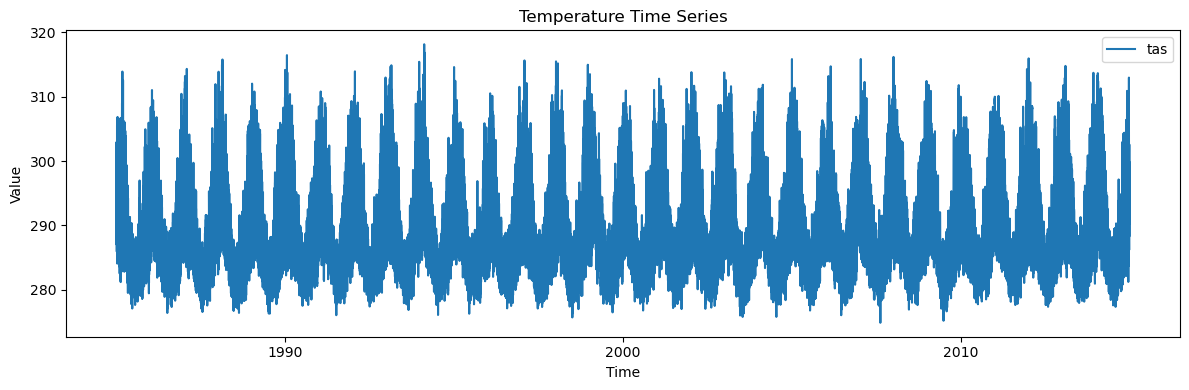

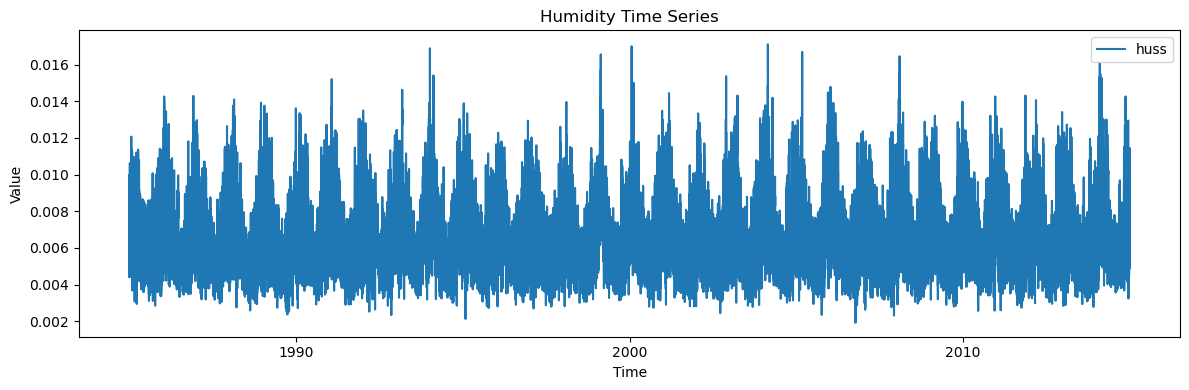

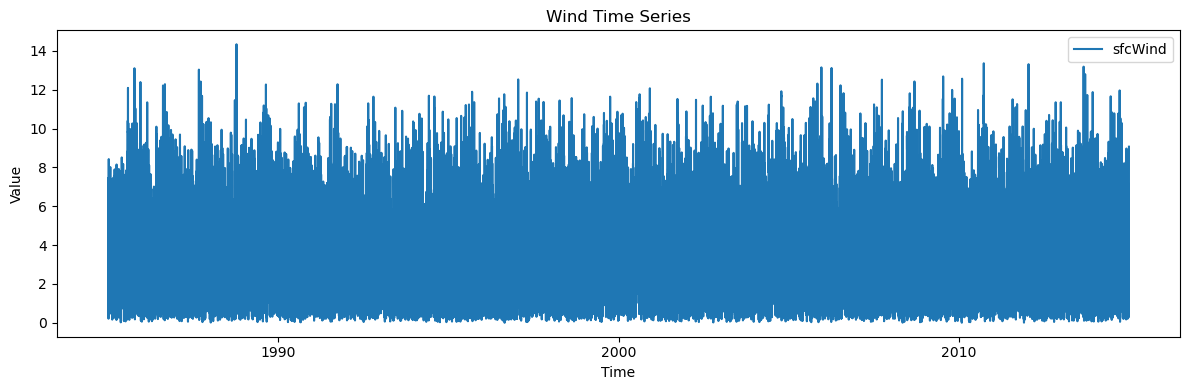

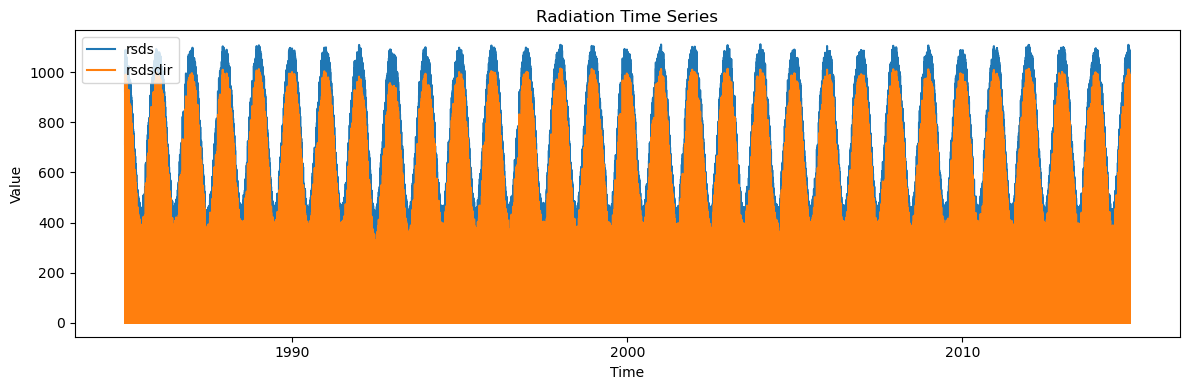

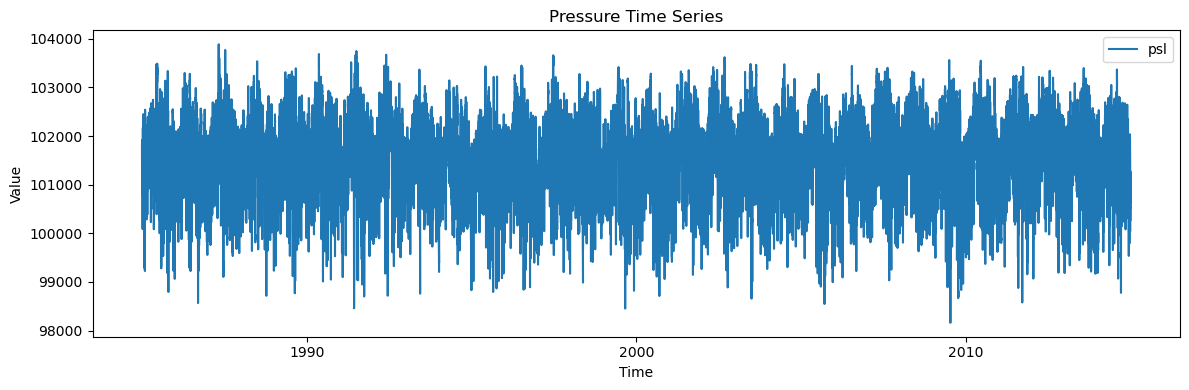

In [20]:
ds_hist = xr.open_dataset(f"{file_dir}step1_raw_data_extraction//BARPA-R/Melbourne_AUS-15_CMCC-ESM2_historical_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_1985-2014.nc")
ds_2050 = xr.open_dataset(f"{file_dir}step1_raw_data_extraction//BARPA-R/Melbourne_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_2035-2064.nc")


plot_groups = {
    'Temperature': ['tas'],
    'Humidity': ['huss'],
    'Wind': ['sfcWind', 'sfcWindmax'],
    'Radiation': ['rsds', 'rsdsdir'],
    'Pressure': ['psl']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in ds_hist:
            ds_hist[var].plot(label=var)
    plt.title(f'{title} Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


### Check hourly data

0


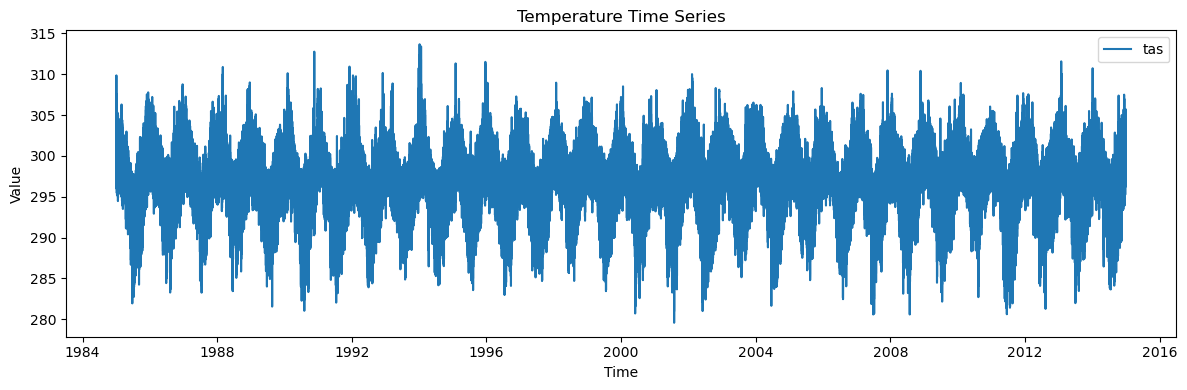

0
0


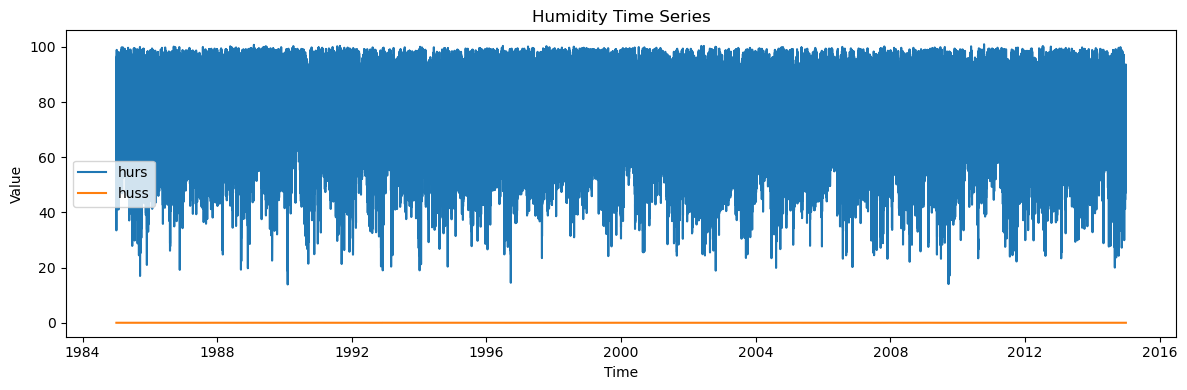

0
0
0


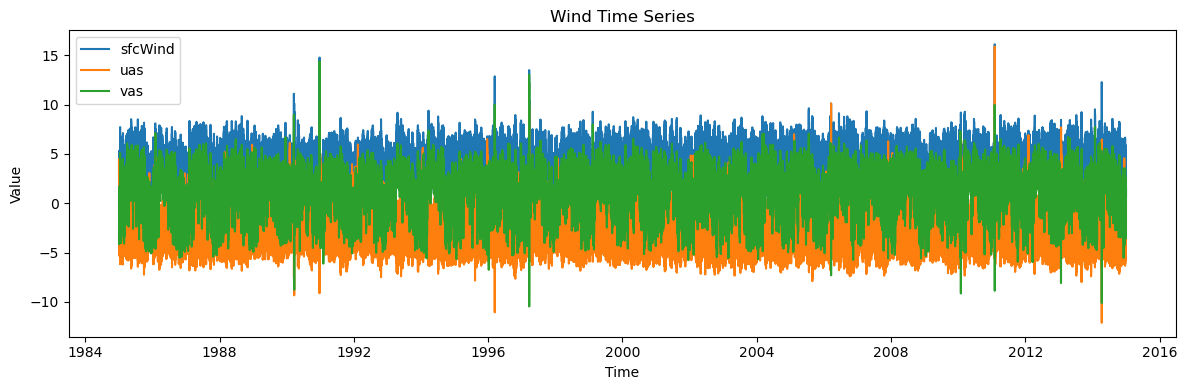

0
0
0


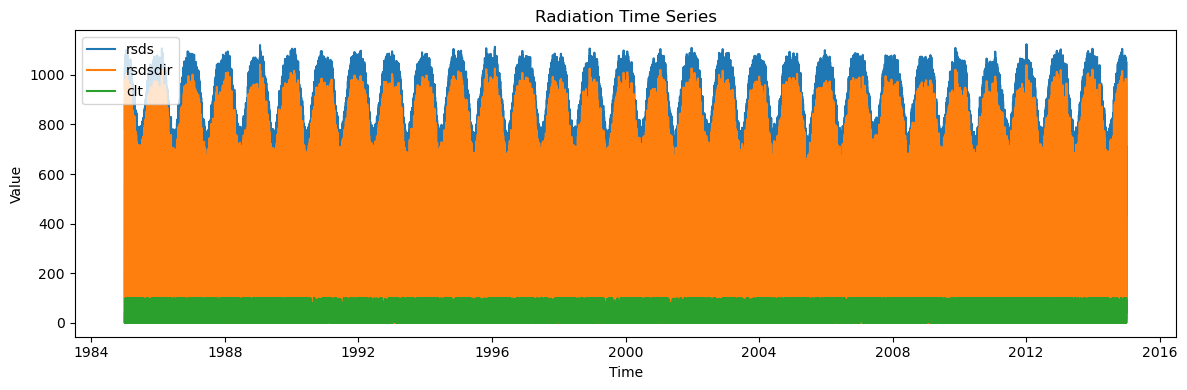

0


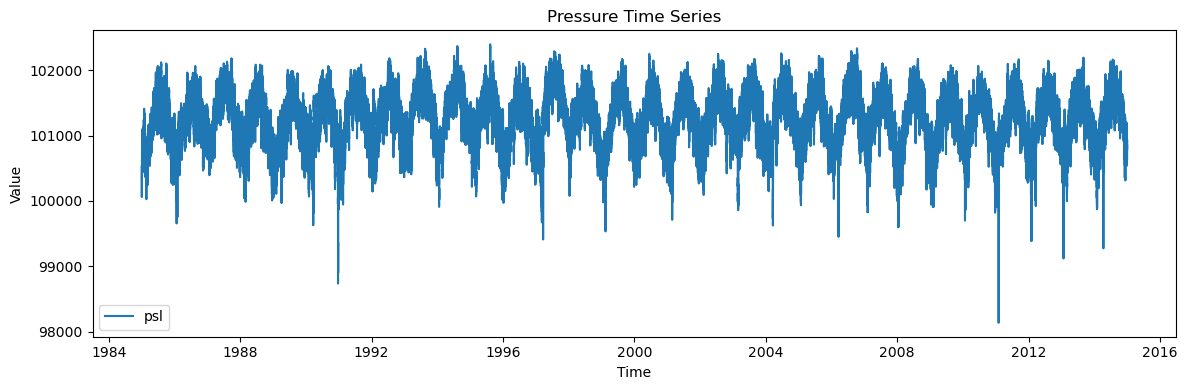

In [4]:
import matplotlib.pyplot as plt
da_var = ['tas','hurs','huss','sfcWind','psl','uas','vas','clt','rsds','rsdsdir']

ds_hist = xr.open_dataset(f"{file_dir}step1_raw_data_extraction/BARRA-R2/Cairns_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_1985-2014.nc")
ds_hist# ds_2050 = xr.open_dataset(f"{file_dir}step1_raw_data_extraction//BARPA-R/Melbourne_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_day_2041-2060.nc")


plot_groups = {
    'Temperature': ['tas'],
    'Humidity': ['hurs', 'huss'],
    'Wind': ['sfcWind', 'uas', 'vas'],
    'Radiation': ['rsds', 'rsdsdir', 'clt'],
    'Pressure': ['psl']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in ds_hist:
            ds_hist[var].plot(label=var)
            print(ds_hist[var].isnull().sum(dim="time").values)
    plt.title(f'{title} Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
da_var = ['tas','hurs','huss','sfcWind','psl','uas','vas','clt','rsds','rsdsdir']
gcms = ['ACCESS-ESM1-5','ACCESS-CM2','MPI-ESM1-2-HR','CMCC-ESM','EC-Earth3','CESM2','NorESM2-MM']

for gcm in gcms:
    print(f"------ {gcm} ------")
    file = glob.glob(f"{file_dir}step1_raw_data_extraction/BARPA-R/Cairns*{gcm}*ssp370*1hr*.nc")[0]
    print(file)
    ds_hist = xr.open_dataset(file)
    for var in da_var:
        if var in ds_hist:
            # ds_hist[var].plot(label=var)
            nans = ds_hist[var].isnull().sum(dim="time").values
            print(f"Number of NaNs in {var}: {nans}")


------ ACCESS-ESM1-5 ------
/g/data/eg3/nesp_bff/step1_raw_data_extraction/BARPA-R/Cairns_AUS-15_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_BARPA-R_v1-r1_1hr_2035-2064.nc
Number of NaNs in tas: 0
Number of NaNs in hurs: 0
Number of NaNs in huss: 0
Number of NaNs in sfcWind: 0
Number of NaNs in psl: 0
Number of NaNs in uas: 0
Number of NaNs in vas: 0
Number of NaNs in clt: 0
Number of NaNs in rsds: 0
Number of NaNs in rsdsdir: 0
------ ACCESS-CM2 ------
/g/data/eg3/nesp_bff/step1_raw_data_extraction/BARPA-R/Cairns_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_1hr_2035-2064.nc
Number of NaNs in tas: 0
Number of NaNs in hurs: 0
Number of NaNs in huss: 0
Number of NaNs in sfcWind: 0
Number of NaNs in psl: 0
Number of NaNs in uas: 0
Number of NaNs in vas: 0
Number of NaNs in clt: 0
Number of NaNs in rsds: 0
Number of NaNs in rsdsdir: 0
------ MPI-ESM1-2-HR ------
/g/data/eg3/nesp_bff/step1_raw_data_extraction/BARPA-R/Cairns_AUS-15_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_2035-2064.n

### Step 2: Checking QDC daily and hourly output

Number of NaNs in tas: 0


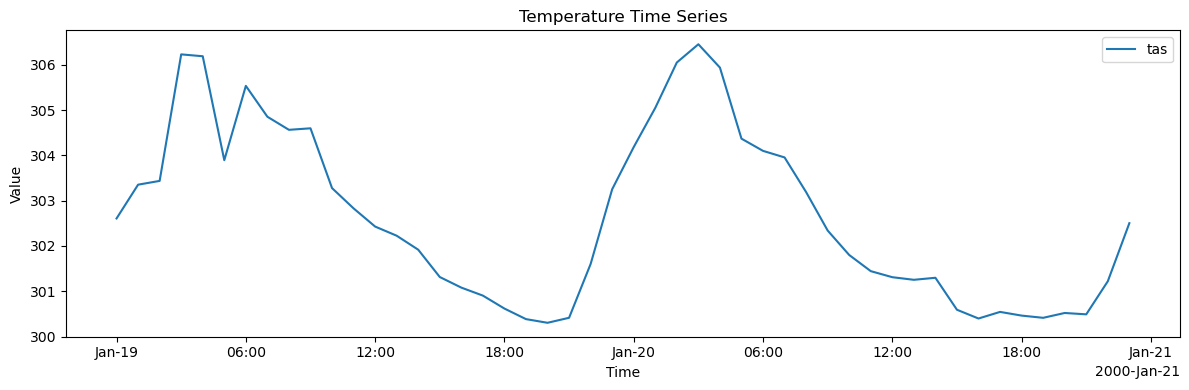

Number of NaNs in huss: 0
Number of NaNs in hurs: 0


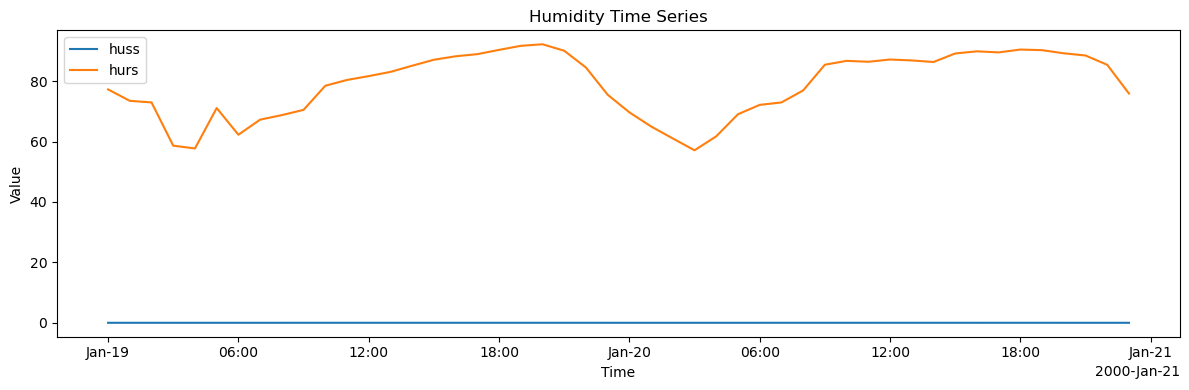

Number of NaNs in sfcWind: 0
Number of NaNs in vas: 0
Number of NaNs in uas: 0


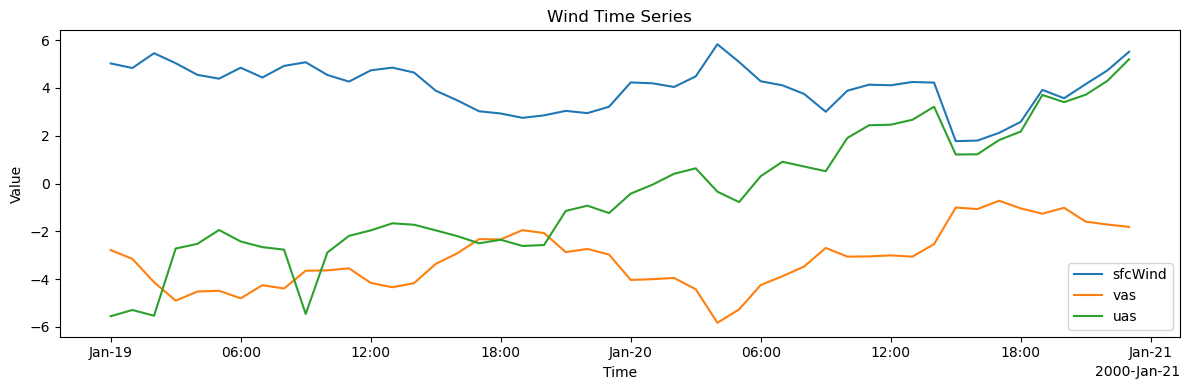

Number of NaNs in rsds: 0
Number of NaNs in rsdsdir: 0


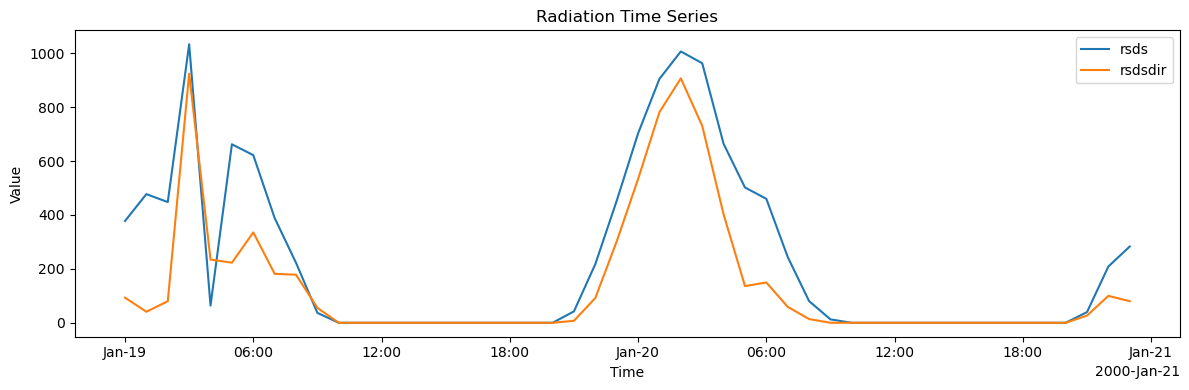

Number of NaNs in psl: 0


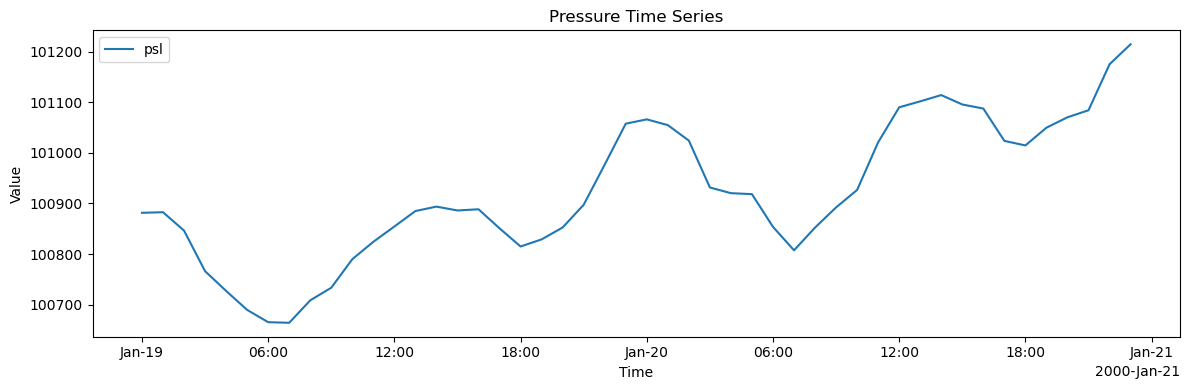

Number of NaNs in clt: 0


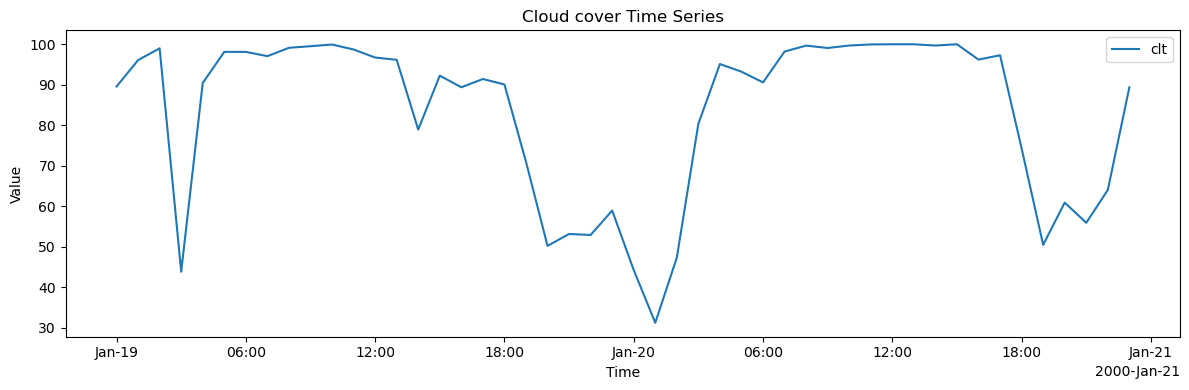

In [28]:
ds_adjust = xr.open_dataset(f"{file_dir}step2_qdc_scaling/BARPA-R/Darwin_AUS-15_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_BARPA-R_v1-r1_1hr_2050_QDC-BARRAR2.nc")
# ds_2050 = xr.open_dataset(f"{file_dir}step2_qdc_scaling/BARPA-R/Darwin_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_1hr_2050_QDC-BARRAR2.nc")
ds_adjust = ds_adjust.sel(time=slice("19-01-2000","20-01-2000"))

plot_groups = {
    'Temperature': ['tas'],
    'Humidity': ['huss','hurs'],
    'Wind': ['sfcWind','vas','uas'],
    'Radiation': ['rsds', 'rsdsdir'],
    'Pressure': ['psl'],
    'Cloud cover': ['clt']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in ds_adjust:
            nans = ds_adjust[var].isnull().sum(dim="time").values
            print(f"Number of NaNs in {var}: {nans}")
            ds_adjust[var].plot(label=var)
    plt.title(f'{title} Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


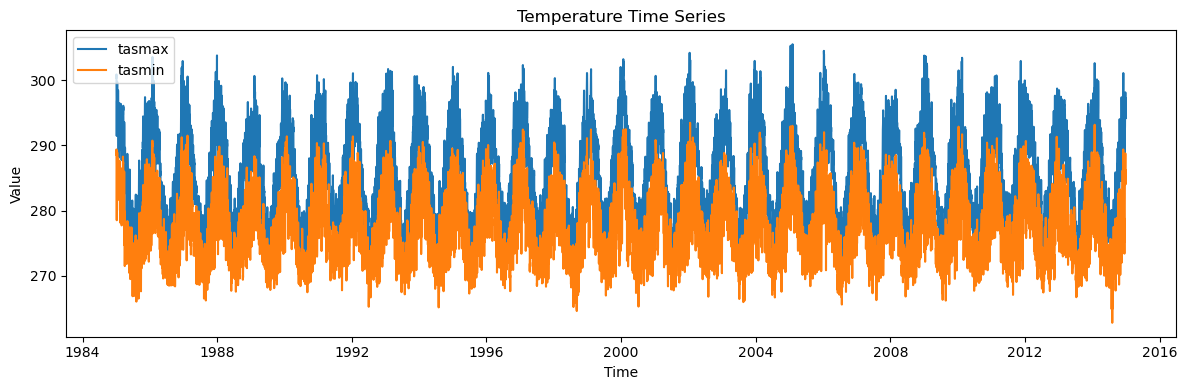

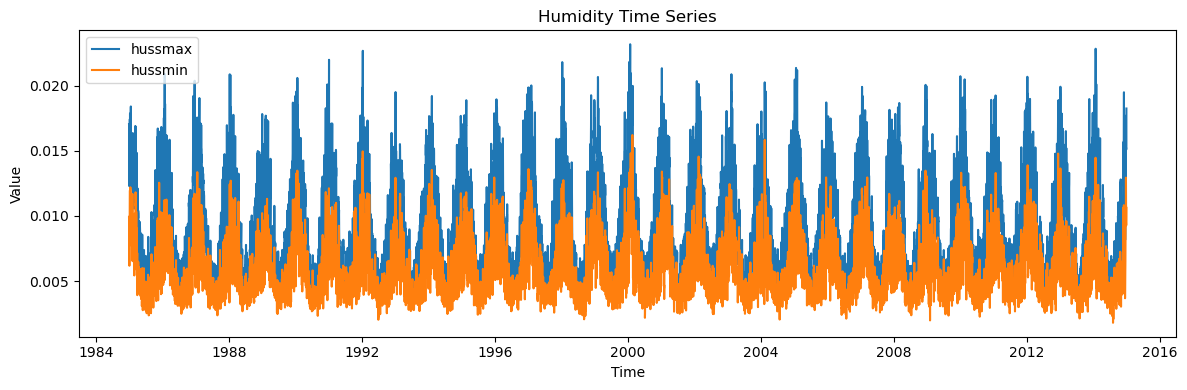

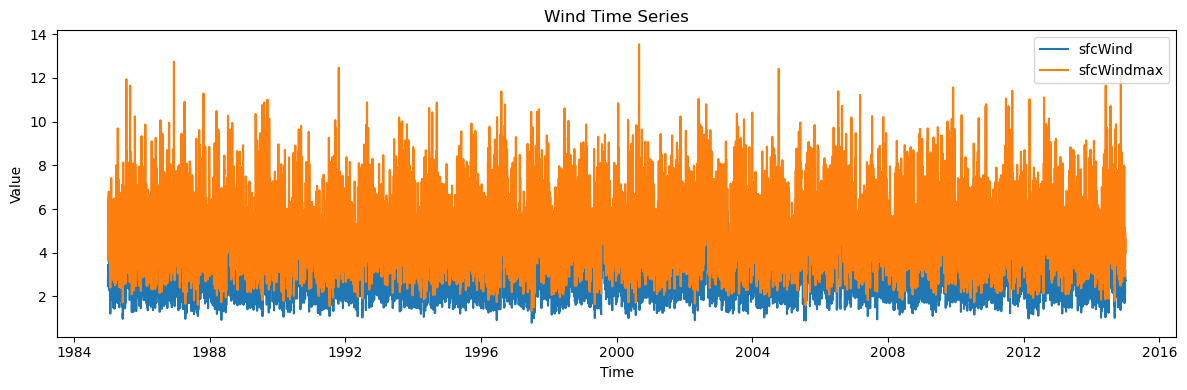

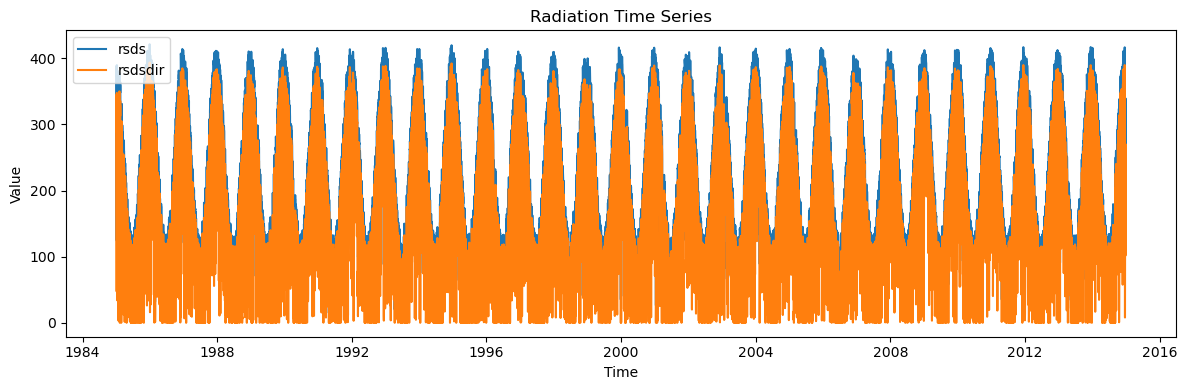

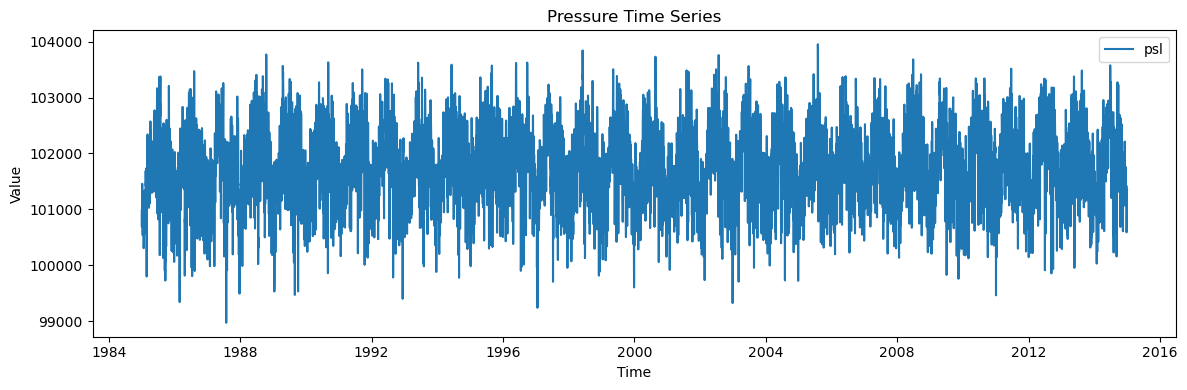

In [11]:
ds_hist = xr.open_dataset(f"{file_dir}step1_raw_data_extraction/CSIRO-CCAM/Thredbo_AUS-10i_ACCESS-ESM1-5_historical_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_day_1985-2014.nc")
ds_hist_barra = xr.open_dataset(f"{file_dir}step1_raw_data_extraction/BARRA-R2/Thredbo_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_1985-2014.nc")

plot_groups = {
    'Temperature': ['tasmax','tasmin'],
    'Humidity': ['hussmax','hussmin'],
    'Wind': ['sfcWind', 'sfcWindmax'],
    'Radiation': ['rsds', 'rsdsdir'],
    'Pressure': ['psl']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in ds_hist:
            ds_hist[var].plot(label=var)
    plt.title(f'{title} Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

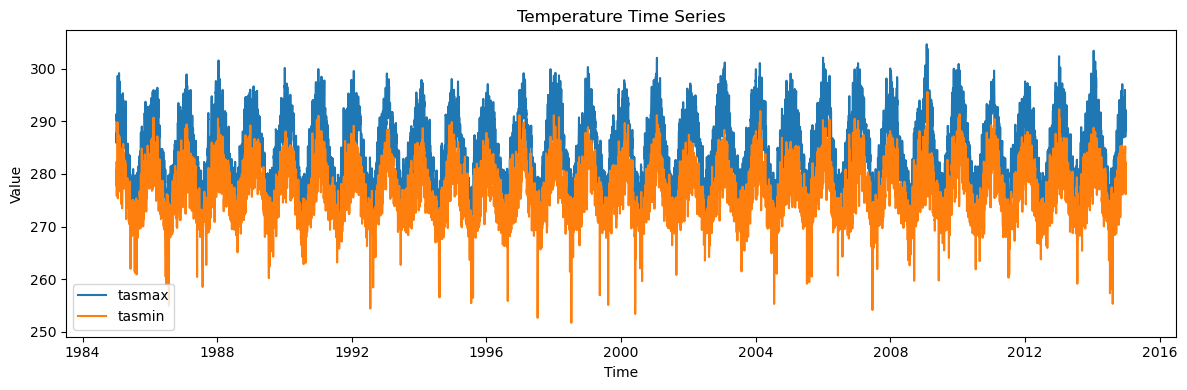

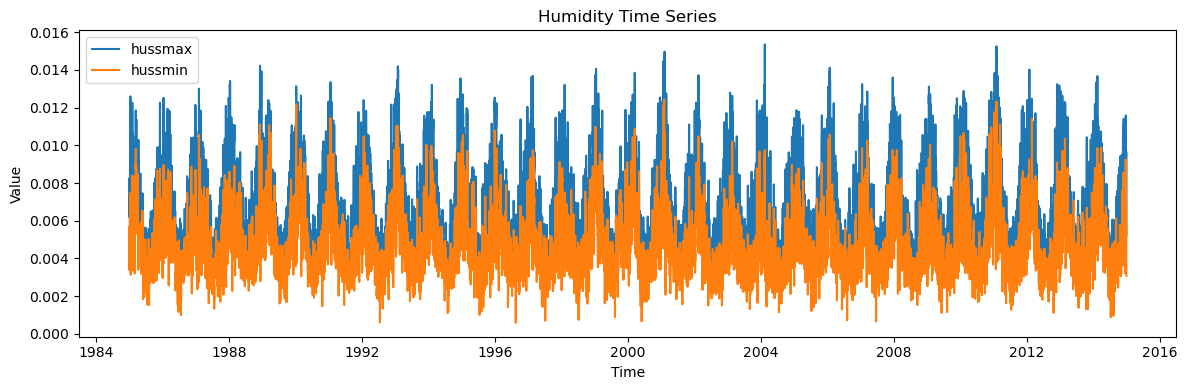

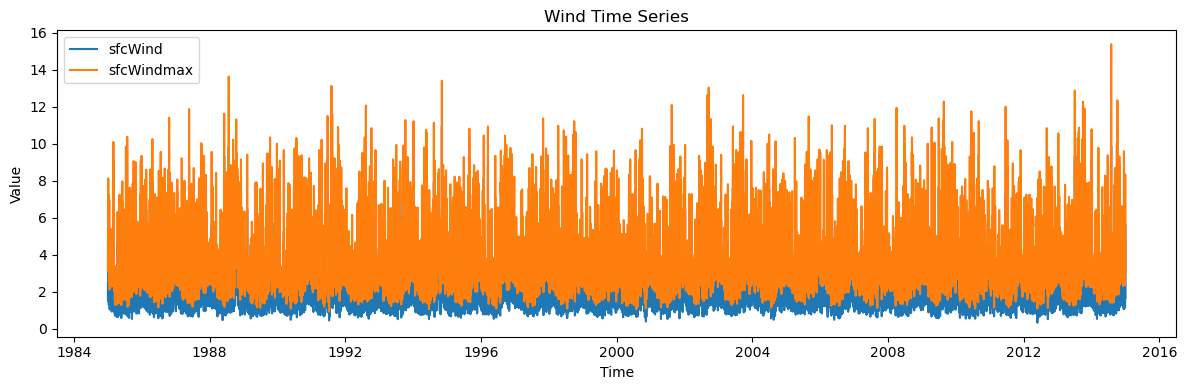

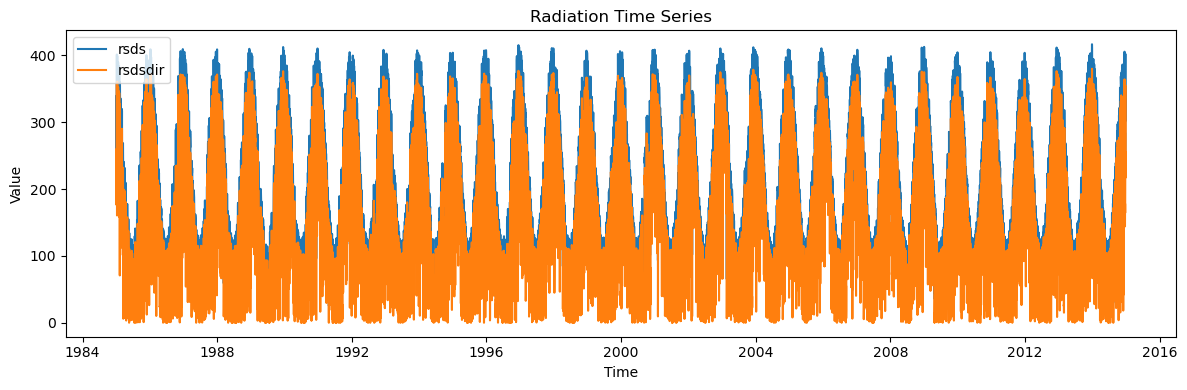

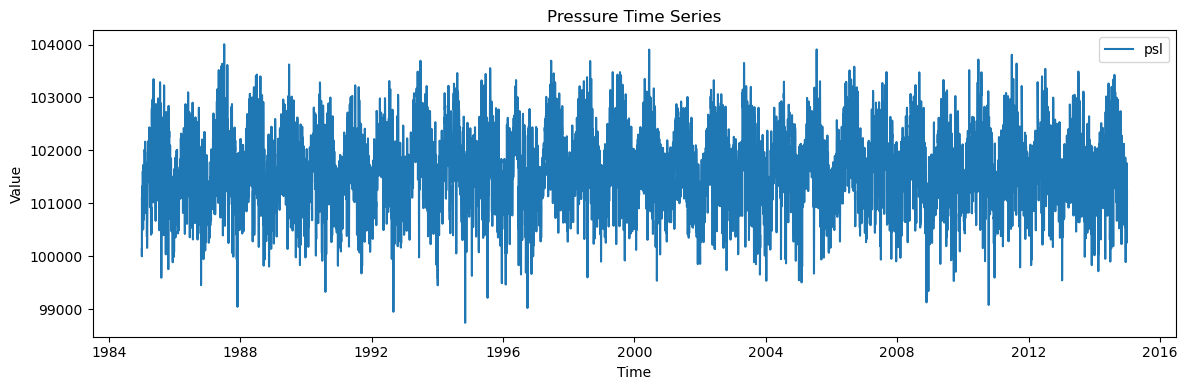

In [12]:
plot_groups = {
    'Temperature': ['tasmax','tasmin'],
    'Humidity': ['hussmax','hussmin'],
    'Wind': ['sfcWind', 'sfcWindmax'],
    'Radiation': ['rsds', 'rsdsdir'],
    'Pressure': ['psl']
}

# Create individual plots
for title, vars in plot_groups.items():
    plt.figure(figsize=(12, 4))
    for var in vars:
        if var in ds_hist_barra:
            ds_hist_barra[var].plot(label=var)
    plt.title(f'{title} Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
a = xr.open_dataset("/g/data/eg3/nesp_bff/step1_raw_data_extraction/CSIRO-CCAM/Cairns_AUS-10i_NorESM2-MM_historical_r1i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_1hr_1985-2014.nc")
a#.tas.plot()

<xarray.Dataset> Size: 25MB
Dimensions:  (time: 525600)
Coordinates:
  * time     (time) object 4MB 1985-01-01 00:00:00 ... 2014-12-31 23:30:00
    lon      float64 8B ...
    lat      float64 8B ...
Data variables:
    tas      (time) float32 2MB ...
    hurs     (time) float32 2MB ...
    huss     (time) float32 2MB ...
    sfcWind  (time) float32 2MB ...
    psl      (time) float32 2MB ...
    uas      (time) float32 2MB ...
    vas      (time) float32 2MB ...
    clt      (time) float32 2MB ...
    rsds     (time) float32 2MB ...
    rsdsdir  (time) float32 2MB ...